# A CNN from scratch

In [11]:
# import the necessary packages
from pyimagesearch.lenet import LeNet
from sklearn.metrics import classification_report
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import torch
import time
import imutils
import cv2
import os

# define training hyperparameters
INIT_LR = 1e-3
BATCH_SIZE = 64
EPOCHS = 10
# define the train and val splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 1 - TRAIN_SPLIT
# set the device we will be using to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# load the KMNIST dataset
print("[INFO] loading the KMNIST dataset...")
trainData = KMNIST(root="data", train=True, download=True,
	transform=ToTensor())
testData = KMNIST(root="data", train=False, download=True,
	transform=ToTensor())
# calculate the train/validation split
print("[INFO] generating the train/validation split...")
numTrainSamples = int(len(trainData) * TRAIN_SPLIT)
numValSamples = int(len(trainData) * VAL_SPLIT)
(trainData, valData) = random_split(trainData,
	[numTrainSamples, numValSamples],
	generator=torch.Generator().manual_seed(42))

[INFO] loading the KMNIST dataset...
[INFO] generating the train/validation split...


In [13]:
# initialize the train, validation, and test data loaders
trainDataLoader = DataLoader(trainData, shuffle=True,
	batch_size=BATCH_SIZE)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
testDataLoader = DataLoader(testData, batch_size=BATCH_SIZE)
# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

In [14]:
# initialize the LeNet model
print("[INFO] initializing the LeNet model...")
model = LeNet(
	numChannels=1,
	classes=len(trainData.dataset.classes)).to(device)
# initialize our optimizer and loss function
opt = Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.NLLLoss()
# initialize a dictionary to store training history
H = {
	"train_loss": [],
	"train_acc": [],
	"val_loss": [],
	"val_acc": []
}
# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()

[INFO] initializing the LeNet model...
[INFO] training the network...


In [ ]:
if os.path.exists("./output/lenet.pth"):

	model.load_state_dict(torch.load("./output/model.pth"))

else:

	from tqdm import tqdm

	# loop over our epochs
	for e in range(0, EPOCHS):
		print("Epoch {}/{}".format(e + 1, EPOCHS), end="\r")
		# set the model in training mode
		model.train()
		# initialize the total training and validation loss
		totalTrainLoss = 0
		totalValLoss = 0
		# initialize the number of correct predictions in the training
		# and validation step
		trainCorrect = 0
		valCorrect = 0
		# loop over the training set
		for (x, y) in tqdm(trainDataLoader, desc="Training", leave=False):
			# send the input to the device
			(x, y) = (x.to(device), y.to(device))
			# perform a forward pass and calculate the training loss
			pred = model(x)
			loss = lossFn(pred, y)
			# zero out the gradients, perform the backpropagation step,
			# and update the weights
			opt.zero_grad()
			loss.backward()
			opt.step()
			# add the loss to the total training loss so far and
			# calculate the number of correct predictions
			totalTrainLoss += loss
			trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

			print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
				loss, trainCorrect / len(trainDataLoader.dataset)))

In [20]:
# switch off autograd for evaluation
with torch.no_grad():
    # set the model in evaluation mode
    model.eval()
    # loop over the validation set
    for (x, y) in valDataLoader:
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # make the predictions and calculate the validation loss
        pred = model(x)
        totalValLoss += lossFn(pred, y)
        # calculate the number of correct predictions
        valCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()

In [21]:
# calculate the average training and validation loss
avgTrainLoss = totalTrainLoss / trainSteps
avgValLoss = totalValLoss / valSteps
# calculate the training and validation accuracy
trainCorrect = trainCorrect / len(trainDataLoader.dataset)
valCorrect = valCorrect / len(valDataLoader.dataset)
# update our training history
H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
H["train_acc"].append(trainCorrect)
H["val_loss"].append(avgValLoss.cpu().detach().numpy())
H["val_acc"].append(valCorrect)
# print the model training and validation information
print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
    avgTrainLoss, trainCorrect))
print("Val loss: {:.6f}, Val accuracy: {:.4f}\n".format(
    avgValLoss, valCorrect))

[INFO] EPOCH: 10/10
Train loss: 0.007217, Train accuracy: 0.9975
Val loss: 0.083003, Val accuracy: 0.9811



In [22]:
# finish measuring how long training took
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))
# we can now evaluate the network on the test set
print("[INFO] evaluating network...")
# turn off autograd for testing evaluation
with torch.no_grad():
	# set the model in evaluation mode
	model.eval()
	
	# initialize a list to store our predictions
	preds = []
	# loop over the test set
	for (x, y) in testDataLoader:
		# send the input to the device
		x = x.to(device)
		# make the predictions and add them to the list
		pred = model(x)
		preds.extend(pred.argmax(axis=1).cpu().numpy())
# generate a classification report
print(classification_report(testData.targets.cpu().numpy(),
	np.array(preds), target_names=testData.classes))

[INFO] total time taken to train the model: 286.26s
[INFO] evaluating network...
              precision    recall  f1-score   support

           o       0.97      0.94      0.95      1000
          ki       0.96      0.94      0.95      1000
          su       0.95      0.91      0.93      1000
         tsu       0.97      0.96      0.97      1000
          na       0.93      0.95      0.94      1000
          ha       0.93      0.96      0.94      1000
          ma       0.93      0.97      0.95      1000
          ya       0.98      0.95      0.97      1000
          re       0.95      0.96      0.96      1000
          wo       0.95      0.95      0.95      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



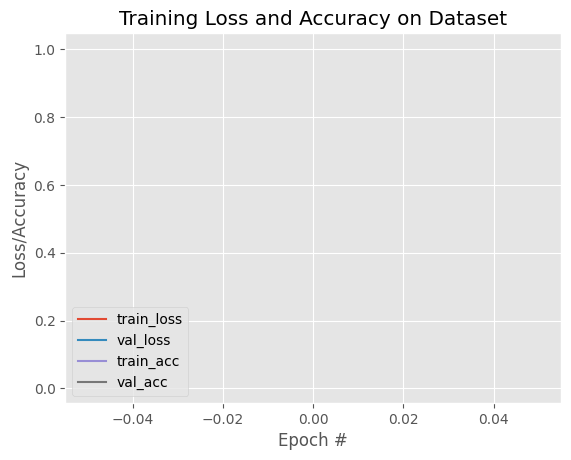

In [23]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("./output/lenet.png")

plt.show()

# serialize the model to disk
torch.save(model, "./output/lenet.pth")

In [24]:
# switch off autograd
with torch.no_grad():
	# loop over the test set
	for (image, label) in testDataLoader:
		# grab the original image and ground truth label
		origImage = image.numpy().squeeze(axis=(0, 1))
		gtLabel = testData.dataset.classes[label.numpy()[0]]
		# send the input to the device and make predictions on it
		image = image.to(device)
		pred = model(image)
		# find the class label index with the largest corresponding
		# probability
		idx = pred.argmax(axis=1).cpu().numpy()[0]
		predLabel = testData.dataset.classes[idx]

ValueError: cannot select an axis to squeeze out which has size not equal to one

In [25]:
# convert the image from grayscale to RGB (so we can draw on
# it) and resize it (so we can more easily see it on our
# screen)
origImage = np.dstack([origImage] * 3)
origImage = imutils.resize(origImage, width=128)
# draw the predicted class label on it
color = (0, 255, 0) if gtLabel == predLabel else (0, 0, 255)
cv2.putText(origImage, gtLabel, (2, 25),
    cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)
# display the result in terminal and show the input image
print("[INFO] ground truth label: {}, predicted label: {}".format(
    gtLabel, predLabel))
cv2.imshow("image", origImage)
cv2.waitKey(0)

NameError: name 'origImage' is not defined